___

- Dans ce notebook on vous propose deux source de prévision de production éolienne (FOR_D, FOR_M) ainsi que la production réalisée d'un parc éolien en France.
- Il s'agit uniquement des prévisions D+1 ( Horizon de prévision entre 24 et 48 heures). Les prévisions du jour J on été générées le jour J-1 à 00:00.
- Lien cas d'usage: Pour les programmes d'appel ( marché SPOT Day Ahead) il faut fournir la prévision de production la veille avant midi pour le lendemain.

- Attention : Seulement 5 mois des données, données incomplètes ( sousperformance, arrêt parc etc.)


Objectif: 
Mettre en place une méthode qui permet d'agréger différents experts au fil de l'eau sans créer un novueau modèle de prévisions et qui est capable de s'adapter automatiquement aux changement du context (météo,saison, sous-performance, amélioration d'un expert etc.)


___

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf


In [3]:
df = pd.read_csv('FRMIR_v1.csv',sep=';',parse_dates=['DateTime'],dayfirst=True)

In [4]:
df['Dates'] = df['DateTime'].dt.day_name() 
df['Time'] = df['DateTime'].dt.time

In [5]:
df

,DateTime,FOR_D,FOR_M,Power,Dates,Time
0,2020-03-05 00:00:00,1561.546745,14654.2,2398.581163,Thursday,00:00:00
1,2020-03-05 01:00:00,1308.262362,3982.0,2327.819766,Thursday,01:00:00
2,2020-03-05 02:00:00,1190.923118,3625.6,1587.336721,Thursday,02:00:00
3,2020-03-05 03:00:00,1697.768798,3269.2,1439.571654,Thursday,03:00:00
4,2020-03-05 04:00:00,1989.946882,3091.0,1375.600484,Thursday,04:00:00
...,...,...,...,...,...,...
2537,2020-07-24 22:00:00,378.737301,2734.6,1161.229859,Friday,22:00:00
2538,2020-07-24 23:00:00,611.716664,2080.1,1239.117910,Friday,23:00:00
2539,2020-07-25 00:00:00,614.771268,2378.2,1613.549091,Saturday,00:00:00
2540,2020-07-25 01:00:00,511.514462,2734.6,2200.139987,Saturday,01:00:00


In [6]:
df['Power']

0       2398.581163
1       2327.819766
2       1587.336721
3       1439.571654
4       1375.600484
           ...     
2537    1161.229859
2538    1239.117910
2539    1613.549091
2540    2200.139987
2541    2487.865467
Name: Power, Length: 2542, dtype: float64

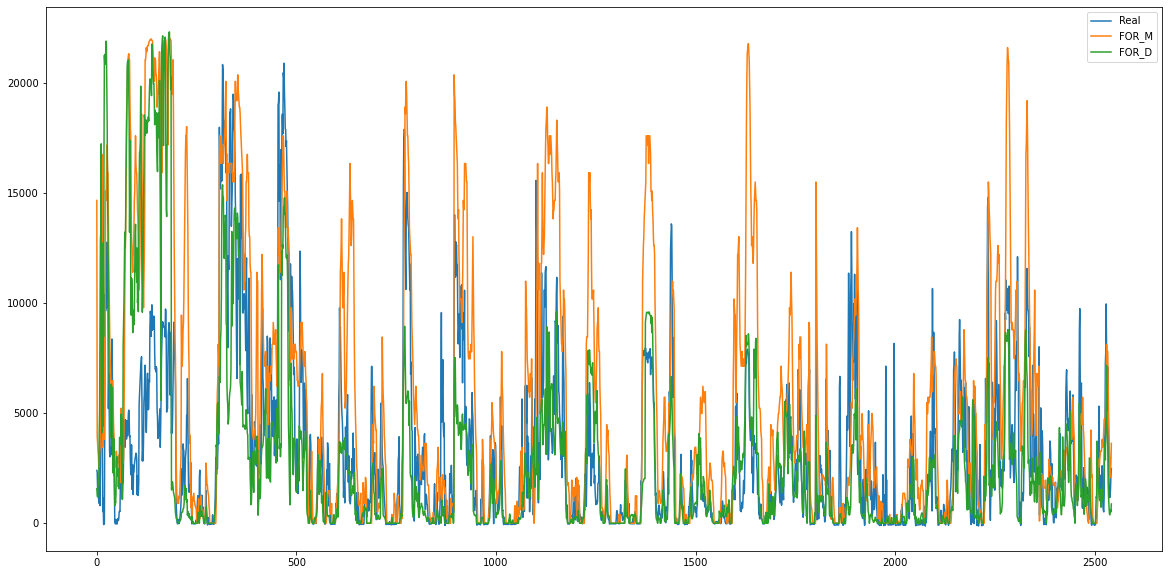

In [7]:
# Day+1
plt.figure(figsize=(20,10))


plt.plot(df['Power'],label='Real')
plt.plot(df['FOR_M'],label='FOR_M')
plt.plot(df['FOR_D'],label='FOR_D')
plt.legend()

----

In [8]:
import numpy as np

## Cette section regroupe des fonctions de métrique d'erreurs

In [9]:
# Mean absoolute error (MAE)

def MAE(Y, Y_chap):
    if len(Y) == len(Y_chap):
        mae = np.sum(np.absolute(Y_chap - Y)) / len(Y)
    else:
        print('Probleme de dimension entre Y et Y_chap')
        print('len(Y) :', len(Y))
        print('len(Y_chap) :', len(Y_chap))
    
    return mae

# Mean absolute percentage error (MAPE)

def MAPE(Y, Y_chap):
    if len(Y) == len(Y_chap):
        AF = (Y - Y_chap)
        for i in range(len(Y)):
            AF[i] = np.absolute(AF[i] / Y[i])
        # 100%/n
        mape = (1/len(Y)) * np.sum(AF)
    else:
        print('Probleme de dimension entre Y et Y_chap')
        print('len(Y) :', len(Y))
        print('len(Y_chap) :', len(Y_chap))

    return MAPE



# Root Mean squared error (MRSE)

def MRSE(Y, Y_chap):
    if len(Y) == len(Y_chap):
        mrse = np.sqrt(((Y_chap - Y)**2).mean()) 
    else:
        print('Probleme de dimension entre Y et Y_chap')
        print('len(Y) :', len(Y))
        print('len(Y_chap) :', len(Y_chap))
    
    return -mrse

## **E**xponential **W**eighted **A**verage (**EWA**)

- Each expert suggests a prediction $f_{i,t}$ of the consumption $y_t$ 

- We assign to expert i the weight

$$
\widehat{p}_{i,t} = \frac{p_{i,t-1}\exp(-\eta*l(f_{i,t},y_t))}{\sum_{j=1}^{N}p_{j,t-1}*\exp(-\eta*l(f_{j,t-1},y_{t-1}))}
$$

- and we predict : $\widehat{y}_t = \sum_{i=1}^{N}\widehat{p}_{i,t-1}*f_{i,t}$

In [300]:
def dist_eucl(value1, value2):
    return np.abs((value1 - value2)) #/  (value1 + value2)

In [301]:
def poids(eta, y, f, last_p, sum_p, step):

    nume = last_p[step-1] * np.exp(-eta*dist_eucl(f[step], y[step]))
    print(nume)

    denom = np.sum(sum_p[step-1] * np.exp(-eta*dist_eucl(f[step-1], y[step-1])))

    p = nume/denom

    return p

In [302]:
def predict(p_i, f_i):
    return np.sum(p_i*f_i) 

In [303]:
p_chap=[1/2]
p_chap2=[1/2]
p_new = list(zip(p_chap, p_chap2))


In [304]:
np.array(p_new)

array([[0.5, 0.5]])

In [305]:
p_chap=[1/2, 1/2]
p_chap2=[1/2, 1/2]


for i in range(1, len(df['Power'][:2000])):
    eta = 0.001
    p_new = np.array(list(zip(p_chap, p_chap2)))
    p_chap.append(poids(eta=eta, y=df['Power'][:2000], f=df['FOR_M'][:2000], last_p = p_chap, sum_p=p_new, step = i))
    p_chap2.append(poids(eta=eta, y=df['Power'][:2000], f=df['FOR_D'][:2000], last_p = p_chap2, sum_p=p_new, step = i))

0.09562438531942466
0.1803772867467808
0.06512736534897448
0.3363641979092919
3224.918882440842
0.3217863993580105
0.061259904222025985
0.5044181067365224
0.2382339954115053
1.0583545949051678e-05
0.14342786197242263
0.06332789275037201
0.9279233394379165
2.2656887814616427e-06
0.06451967787124938
6.831707563417838e-05
0.1660470363101764
4.6307038544095007e-10
0.005127435455575587
7.490803132217224e-08
0.42816491099090614
6.523327110904293e-11
0.32352980866660896
3.73121703404748e-05
0.013041472163127997
3.232901500513875e-10
0.25305557346721796
0.0001059146535535927
0.0003980990388558507
1.6543235844908137e-09
0.0008338719212894957
5.559960457012483e-07
0.0005963319625498959
1.8622351363635922e-07
6.1381237590325354e-06
2.246748122565136e-14
1.038280085627554
4.7402588249731004e-11
1.9141621866699703
4.9424007385297555e-14
0.17188343079879365
1.2630113616384409e-10
0.1387395286906428
1.0701753601813787e-10
0.029800256323508603
2.725772583713646e-08
2.6645247164659944e-05
1.12604387066

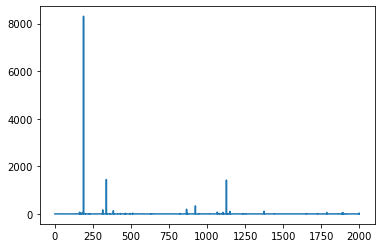

In [285]:
plt.plot(p_chap2)

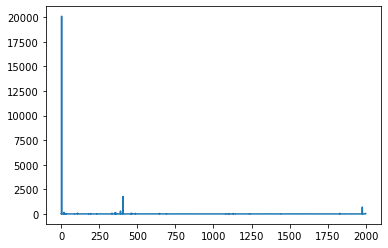

In [286]:
plt.plot(p_chap)

In [287]:
p = np.array(list(zip(p_chap, p_chap2)))
f = np.array(list(zip(df['FOR_M'], df['FOR_D'])))

In [288]:
y_t = []
for i in range(1, len(p)):
    y_t.append(predict(p[i-1], f[i]))

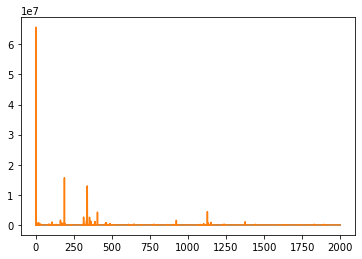

In [289]:
plt.plot(df['Power'][:2000])
plt.plot(y_t)


Maintenant que nous avons un début de poids nous allons essayer de le faire sans le mode oracle. Nous prenons la prediction y_t que nous définissons comme l'y de notre formule (on suppose que la prediction est bonne) 

In [290]:
dfM = df['FOR_M'][2000:].reset_index(drop = True)


In [291]:
predict_y_t = [y_t[1998], y_t[1999]]
p_chap_prim = [p_chap[1999], p_chap[2000]]
p_chap2_prim = [p_chap2[1999], p_chap2[2000]]
dfM = df['FOR_M'][2000:].reset_index(drop = True)
dfD = df['FOR_D'][2000:].reset_index(drop = True)

for i in range(1, len(df['Power'][2000:])):
    p_new = np.array(list(zip(p_chap_prim, p_chap2_prim)))
    p_chap_prim.append(poids(eta=0.1, y=predict_y_t, f=dfM, last_p = p_chap_prim, sum_p=p_new, step = i))
    p_chap2_prim.append(poids(eta=0.1, y=predict_y_t, f=dfD, last_p = p_chap2_prim, sum_p=p_new, step = i))
    
    predict_y_t.append(predict(p_new[i-1], f[i]))

7.461064596773386e-11
1.0400511944825123e-12
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

/var/folders/cn/f38f6tmd3578_byfz3k483000000gn/T/ipykernel_98108/2947601580.py:8: RuntimeWarning: invalid value encountered in double_scalars
  p = nume/denom


____

## Brouillon fonctionnel 

In [ ]:
def dist_eucl(value1, value2):
    a = []
    for (i,j) in zip(value1, value2):
        a.append(np.sqrt((i - j)**2) /  (i + j))
    return np.array(a)


def REL(y, p_chap):
    return y*np.log(y/p_chap)+(1-y)*np.log((1-y) / (1-p_chap))

In [ ]:
a = []
for (x,j) in zip(df['Power'], df['FOR_M']):
    a.append((x-j)**2)

In [ ]:
a

[150200193.07078657,
 2736312.2476424696,
 4154517.1939915833,
 3347539.883178156,
 2942595.499299004,
 2699830.578670024,
 544056.4754869797,
 21629.654277216883,
 7017870.664007282,
 5693000.830520059,
 6736349.164550269,
 1235127.219939667,
 832896.3855664514,
 33915543.75237967,
 2324133.445401287,
 8513182.891266447,
 122423180.84192052,
 36378719.37021109,
 14846372.586144397,
 24916712.5676135,
 2332922.178850451,
 386691.6869727929,
 29587405.44920905,
 19525459.579433907,
 32664816.8331631,
 22751296.770284858,
 15899629.175390711,
 12181697.456669567,
 33161808.394143477,
 74113930.56395349,
 25165212.525506172,
 27046255.796632938,
 34009919.36991344,
 22809505.839222454,
 13374318.215580117,
 11401127.724259334,
 7615460.119200761,
 2333388.8352493304,
 4606813.93158529,
 18564.973364409278,
 734275.8023428116,
 1589895.0510126194,
 2120883.0665199975,
 3201351.2940839706,
 1010590.8633378987,
 7096530.450806427,
 6622378.179152418,
 6693617.106016916,
 5678506.4264221275,


In [ ]:
def EWAF(true, agent_pred_M, agent_pred_D, teta = 0.3):
    
    w_M = np.zeros(len(true))
    w_D = np.zeros(len(true))

    print(REL(true, agent_pred_M))

    distance_euclid_M = dist_eucl(true, agent_pred_M)
    distance_euclid_D = dist_eucl(true, agent_pred_D)

    w_M[0] = 0.5
    w_D[0] = 0.5

    for i in range(len(true) - 1):
        w_M[i+1] = w_M[i]*np.exp(-teta * distance_euclid_M[i+1]) / (w_M[i]*np.exp(-teta * distance_euclid_M[i+1]) + w_D[i]*np.exp(-teta * distance_euclid_D[i+1]))
        w_D[i+1] = w_D[i]*np.exp(-teta * distance_euclid_D[i+1]) / (w_M[i]*np.exp(-teta * distance_euclid_M[i+1]) + w_D[i]*np.exp(-teta * distance_euclid_D[i+1]))

    return w_M, w_D

In [ ]:
ewaf_for_M, ewaf_for_D = EWAF(true = df['Power'][:2000], agent_pred_M = df['FOR_M'][:2000], agent_pred_D = df['FOR_D'][:2000])


0      -0.973674
1      -0.121475
2      -0.263875
3      -0.260652
4      -0.254750
          ...   
1995         NaN
1996         NaN
1997         NaN
1998         NaN
1999         NaN
Length: 2000, dtype: float64


/opt/anaconda3/envs/arsene/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
(ewaf_for_D+ewaf_for_M).mean()

1.0

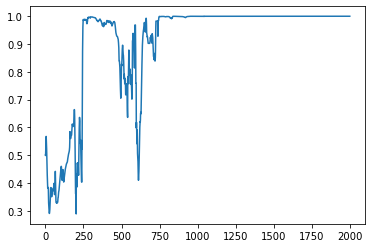

In [ ]:
plt.plot(ewaf_for_D)

In [ ]:
ewaf_for_M.mean()

0.09260029992688723

In [ ]:
ewaf_for_D.mean()

0.9073997000731128

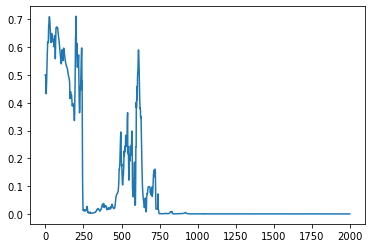

In [ ]:
plt.plot(ewaf_for_M)

In [ ]:
ewaf_for_M

array([5.00000000e-01, 5.01368021e-01, 4.82751110e-01, ...,
       1.85975562e-29, 1.85975562e-29, 1.85975562e-29])

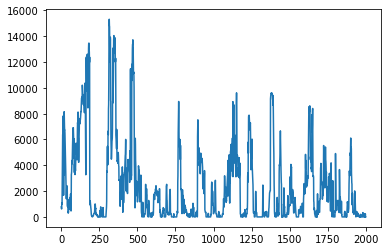

In [ ]:
plt.plot(ewaf_for_D*df['FOR_D'][:2000])

In [ ]:
ewaf_for_D 

array([0.5       , 0.49863198, 0.51724889, ..., 1.        , 1.        ,
       1.        ])

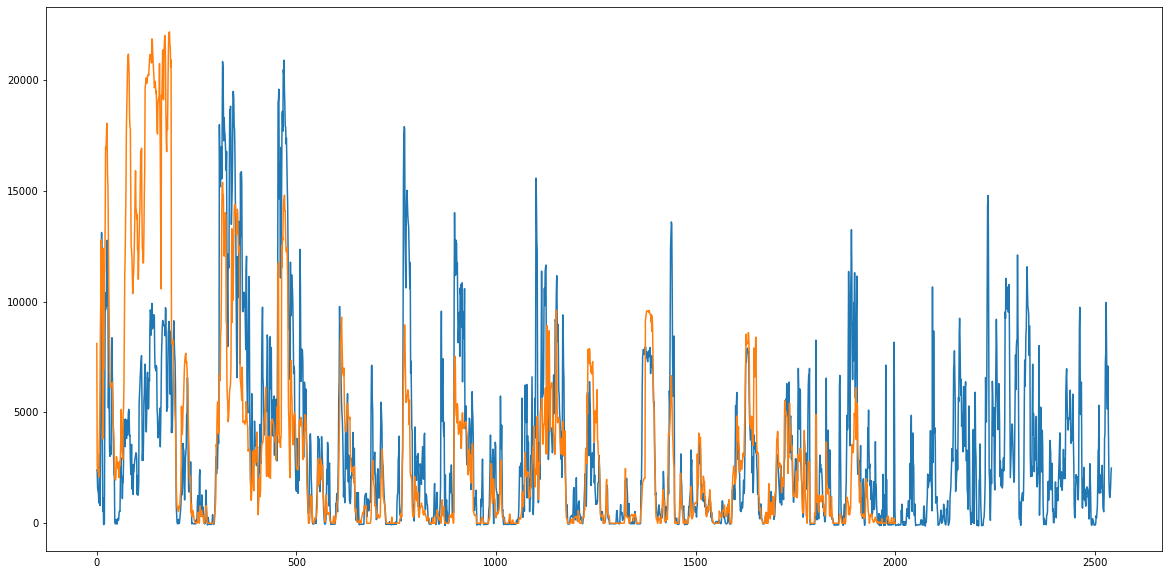

In [ ]:
new = ewaf_for_M * df['FOR_M'][:2000] + ewaf_for_D*df['FOR_D'][:2000]

plt.figure(figsize=(20,10))
plt.plot(df['Power'])
plt.plot(new)


In [ ]:
dist_eucl(new[250:], df['Power'][250:]).mean()

0.27479971986269774

In [ ]:
df['FOR_M']

0       14654.2
1        3982.0
2        3625.6
3        3269.2
4        3091.0
         ...   
2537     2734.6
2538     2080.1
2539     2378.2
2540     2734.6
2541     3625.6
Name: FOR_M, Length: 2542, dtype: float64

In [ ]:
df['FOR_D']

0       1561.546745
1       1308.262362
2       1190.923118
3       1697.768798
4       1989.946882
           ...     
2537     378.737301
2538     611.716664
2539     614.771268
2540     511.514462
2541     874.242626
Name: FOR_D, Length: 2542, dtype: float64

In [ ]:
ewaf_for_M[-1]

1.8597556223478712e-29

In [ ]:
ewaf_for_D[-1]

1.0

In [ ]:
def dist_eucl(value1, value2):
    return np.abs((value1 - value2)) #/  (value1 + value2)

In [ ]:
distance_euclid_M = []
distance_euclid_D = []

w_M = [0]
w_D = [1.0]

def EWAF_step_2(true, agent_pred_M, agent_pred_D, i, teta = 0.3):
    
    distance_euclid_M.append(dist_eucl(true, agent_pred_M))
    distance_euclid_D.append(dist_eucl(true, agent_pred_D))

    
    w_M.append(w_M[i]*np.exp(-teta * distance_euclid_M[i]) / (w_M[i]*np.exp(-teta * distance_euclid_M[i]) + w_D[i]*np.exp(-teta * distance_euclid_D[i])))
    w_D.append(w_D[i]*np.exp(-teta * distance_euclid_D[i]) / (w_M[i]*np.exp(-teta * distance_euclid_M[i]) + w_D[i]*np.exp(-teta * distance_euclid_D[i])))

    y_t = w_M[i] * agent_pred_M + w_D[i] * agent_pred_D
    
    return w_M, w_D, y_t

In [ ]:
y_pred = new.tolist()
step=0

for i in range (len(df['FOR_M'][2000:])) :   
    print('step = ', step)
    step+=1
    p_M, p_D, y_t = EWAF_step_2(true = y_pred[1999+i], agent_pred_M = df['FOR_M'][1999+i], agent_pred_D = df['FOR_D'][1999+i], i = i)
    print("y_t : ",y_pred[1999+i])
    y_pred.append(y_t)
    print("y_ t+1 : ", y_pred[1999+i+1])

step =  0
y_t :  0.0
y_ t+1 :  0.0
step =  1
y_t :  0.0
y_ t+1 :  0.0
step =  2
y_t :  0.0
y_ t+1 :  311.900869
step =  3
y_t :  311.900869
y_ t+1 :  343.940016
step =  4
y_t :  343.940016
y_ t+1 :  263.920706
step =  5
y_t :  263.920706
y_ t+1 :  202.072888
step =  6
y_t :  202.072888
y_ t+1 :  0.0
step =  7
y_t :  0.0
y_ t+1 :  0.0
step =  8
y_t :  0.0
y_ t+1 :  0.0
step =  9
y_t :  0.0
y_ t+1 :  0.0
step =  10
y_t :  0.0
y_ t+1 :  0.0
step =  11
y_t :  0.0
y_ t+1 :  0.0
step =  12
y_t :  0.0
y_ t+1 :  0.0
step =  13
y_t :  0.0
y_ t+1 :  0.0
step =  14
y_t :  0.0
y_ t+1 :  0.0
step =  15
y_t :  0.0
y_ t+1 :  0.0
step =  16
y_t :  0.0
y_ t+1 :  339.244299
step =  17
y_t :  339.244299
y_ t+1 :  395.410312
step =  18
y_t :  395.410312
y_ t+1 :  287.521285
step =  19
y_t :  287.521285
y_ t+1 :  297.62516
step =  20
y_t :  297.62516
y_ t+1 :  298.522466
step =  21
y_t :  298.522466
y_ t+1 :  295.945434
step =  22
y_t :  295.945434
y_ t+1 :  306.811211
step =  23
y_t :  306.811211
y_ t+1 :

/var/folders/cn/f38f6tmd3578_byfz3k483000000gn/T/ipykernel_96018/3241119563.py:13: RuntimeWarning: invalid value encountered in double_scalars
  w_M.append(w_M[i]*np.exp(-teta * distance_euclid_M[i]) / (w_M[i]*np.exp(-teta * distance_euclid_M[i]) + w_D[i]*np.exp(-teta * distance_euclid_D[i])))
/var/folders/cn/f38f6tmd3578_byfz3k483000000gn/T/ipykernel_96018/3241119563.py:14: RuntimeWarning: invalid value encountered in double_scalars
  w_D.append(w_D[i]*np.exp(-teta * distance_euclid_D[i]) / (w_M[i]*np.exp(-teta * distance_euclid_M[i]) + w_D[i]*np.exp(-teta * distance_euclid_D[i])))


 nan
y_ t+1 :  nan
step =  393
y_t :  nan
y_ t+1 :  nan
step =  394
y_t :  nan
y_ t+1 :  nan
step =  395
y_t :  nan
y_ t+1 :  nan
step =  396
y_t :  nan
y_ t+1 :  nan
step =  397
y_t :  nan
y_ t+1 :  nan
step =  398
y_t :  nan
y_ t+1 :  nan
step =  399
y_t :  nan
y_ t+1 :  nan
step =  400
y_t :  nan
y_ t+1 :  nan
step =  401
y_t :  nan
y_ t+1 :  nan
step =  402
y_t :  nan
y_ t+1 :  nan
step =  403
y_t :  nan
y_ t+1 :  nan
step =  404
y_t :  nan
y_ t+1 :  nan
step =  405
y_t :  nan
y_ t+1 :  nan
step =  406
y_t :  nan
y_ t+1 :  nan
step =  407
y_t :  nan
y_ t+1 :  nan
step =  408
y_t :  nan
y_ t+1 :  nan
step =  409
y_t :  nan
y_ t+1 :  nan
step =  410
y_t :  nan
y_ t+1 :  nan
step =  411
y_t :  nan
y_ t+1 :  nan
step =  412
y_t :  nan
y_ t+1 :  nan
step =  413
y_t :  nan
y_ t+1 :  nan
step =  414
y_t :  nan
y_ t+1 :  nan
step =  415
y_t :  nan
y_ t+1 :  nan
step =  416
y_t :  nan
y_ t+1 :  nan
step =  417
y_t :  nan
y_ t+1 :  nan
step =  418
y_t :  nan
y_ t+1 :  nan
step =  419
y_t :  

In [ ]:
len(new)

2000

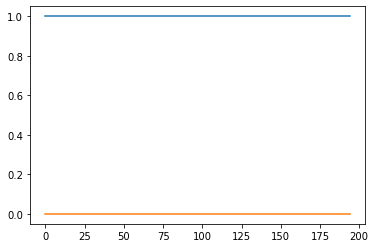

In [ ]:
plt.plot(p_D)
plt.plot(p_M)

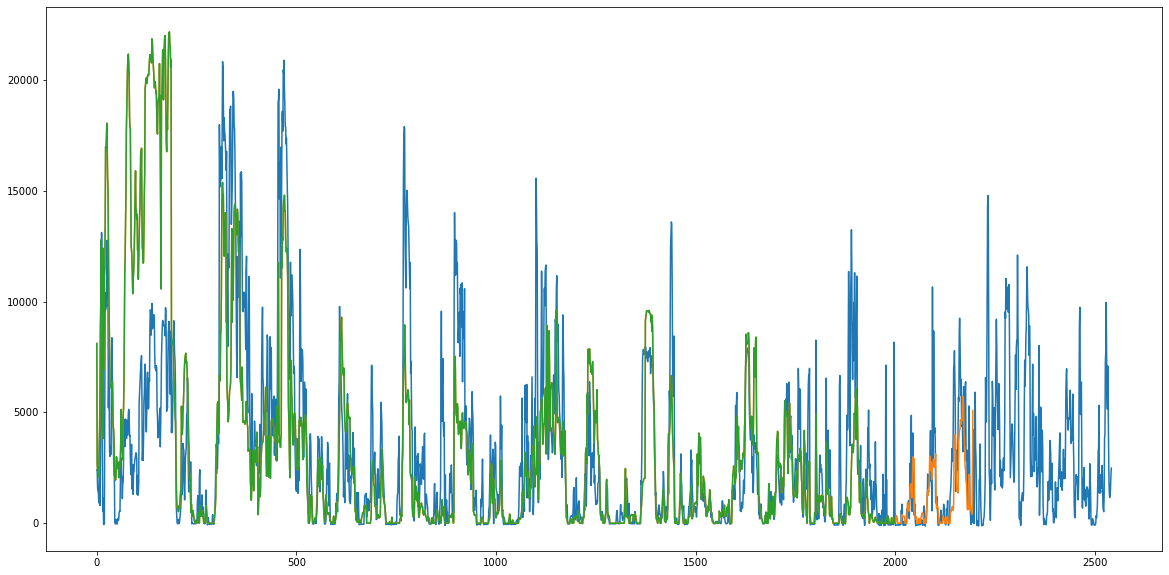

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df['Power'])
plt.plot(y_pred)
plt.plot(new)
